In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Tarefa 3 - Neural Networks
Third assessed coursework for the course: Técnicas e Algoritmos em Ciência de Dados

This tarefa provides an exciting opportunity for students to put their knowledge acquired in class into practice, using neural networks to solve real-world problems in both classification and regression. Students will apply the concepts they have learned to build, train, and optimize neural networks, using a validation set to fine-tune hyperparameters. Students will also get used to generating important plots during training to analyse the models' behaviour. By the end of the project, students will have gained hands-on experience in implementing neural networks.

## General guidelines:

* This work must be entirely original. You are allowed to research documentation for specific libraries, but copying solutions from the internet or your classmates is strictly prohibited. Any such actions will result in a deduction of points for the coursework.
* Please enter your code in the designated areas of the notebook. You can create additional code cells to experiment with, but __make sure to place your final solutions where they are requested in the notebook.__
* Before submitting your work, make sure to rename the file to the random number that you created for the previous coursework (for example, 289479.ipynb).

## Notebook Overview:

1. [Regression](#Regression) (50%)
2. [Classification](#Classification) (50%)

# Regression

**Download from ECLASS**
- Tarefa_3_template.ipynb
- energy_efficiency.csv

**Dataset and Problem Description**

In this exercise, you will use the Energy Efficiency Prediction dataset. This dataset contains information about the energy efficiency of buildings based on eight features, including the size of the building, the orientation, and the type of building materials used. The dataset includes two targets: heating load and cooling load, which represent the energy required to heat and cool the building, respectively.

This dataset is useful for building neural networks that predict the energy efficiency of buildings, which is an important problem in the field of sustainable energy. The dataset has been used in several machine learning research papers and provides a challenging regression problem.

**Exercise Description: Energy Efficiency Prediction with Neural Networks**

In this exercise, you will use the Energy Efficiency Prediction dataset provided.
You will build and train a neural network to predict the heating load (column labelled y1 in the dataset) and the cooling load (column labelled y2) of a building based on its energy efficiency features. 


### To complete this exercise, you will write code to build and train neural networks for this problem:

1. Split the dataset into training, validation, and test sets, using a 70:15:15 ratio.

2. Use numpy, build a neural network that takes the energy efficiency features as input and predicts the heating and the cooling load as outputs. You will choose the number of neurons per layers and the number of layers, but each layer will have the same number of neurons. These two values must be input parameters for your neural network. That is, you can’t hard-code each layer, meaning that you will have to write code that is able to work with a variable number of layers and neurons. 

3. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Monitor the training by plotting the training and validation losses across the epochs. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 0.001 and 0.0001.
To choose the best network configuration and assess its performance you will:

1. Choose 3 possible values of number hidden layers (for example, 1 to 3) and 3 different values of neurons per layer (for example, 100, 200, and 300), but you can also choose different values. 

2. Calculate the loss for each configuration on the validation set.

3. Generate 3 heatmaps, one for each value of the λ regularization parameter, displaying the loss on the validation set by plotting the number of layers and number of neurons in a grid. This will help you visualise the best configuration for the neural network. 

4. Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the root mean squared error as the metric and report that.

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.


In [48]:
# Load the dataset
data = pd.read_csv("energy_efficiency.csv")

# Split features and targets
X = data.iloc[:, :-2].values
y1 = data.iloc[:, -2].values  # Heating Load
y2 = data.iloc[:, -1].values  # Cooling Load

# Split the data into training, validation, and test sets
def train_val_test_split(X, y1, y2, train_ratio=0.7, val_ratio=0.15):
    n = len(X)
    train_size = int(train_ratio * n)
    val_size = int(val_ratio * n)
    indices = np.random.permutation(n)
    train_idx, val_idx, test_idx = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]
    return X[train_idx], X[val_idx], X[test_idx], y1[train_idx], y1[val_idx], y1[test_idx], y2[train_idx], y2[val_idx], y2[test_idx]

X_train, X_val, X_test, y1_train, y1_val, y1_test, y2_train, y2_val, y2_test = train_val_test_split(X, y1, y2)

# Standardize the features
def standardize(train, val, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    train_std = (train - mean) / std
    val_std = (val - mean) / std
    test_std = (test - mean) / std
    return train_std, val_std, test_std

X_train, X_val, X_test = standardize(X_train, X_val, X_test)

In [49]:
class NeuralNetwork:
    def __init__(self, input_dim, output_dim, hidden_layers, neurons_per_layer, lambd=0):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_layers = hidden_layers
        self.neurons_per_layer = neurons_per_layer
        self.lambd = lambd
        self.weights = []
        self.biases = []
        self.init_weights()

    def init_weights(self):
        layer_dims = [self.input_dim] + [self.neurons_per_layer] * self.hidden_layers + [self.output_dim]
        for i in range(len(layer_dims) - 1):
            self.weights.append(np.random.randn(layer_dims[i], layer_dims[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_dims[i+1])))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(self.activations[-1], w) + b
            self.z_values.append(z)
            self.activations.append(self.sigmoid(z))
        return self.activations[-1]

    def backward(self, X, y, output):
        deltas = [output - y]
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[-1], self.weights[i + 1].T) * self.sigmoid_derivative(self.activations[i + 1])
            deltas.append(delta)
        deltas.reverse()

        dw = [np.dot(self.activations[i].T, deltas[i]) / X.shape[0] for i in range(len(self.weights))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / X.shape[0] for i in range(len(self.biases))]

        for i in range(len(self.weights)):
            dw[i] += self.lambd * self.weights[i] / X.shape[0]

        return dw, db

    def update_weights(self, dw, db, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dw[i]
            self.biases[i] -= learning_rate * db[i]

    def compute_loss(self, y, output):
        m = y.shape[0]
        data_loss = np.sum((y - output) ** 2) / (2 * m)
        reg_loss = (self.lambd / (2 * m)) * sum([np.sum(np.square(w)) for w in self.weights])
        return data_loss + reg_loss

    def train(self, X, y, epochs, learning_rate, X_val, y_val):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            dw, db = self.backward(X, y, output)
            self.update_weights(dw, db, learning_rate)
            train_loss = self.compute_loss(y, output)
            val_output = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_output)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}')
        return train_losses, val_losses

In [50]:
# Train the neural network with different configurations
def experiment(layers_list, neurons_list, lambdas, input_dim, output_dim, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, learning_rate=0.01):
    best_config = None
    best_val_loss = float('inf')
    results = []

    for lambd in lambdas:
        for layers in layers_list:
            for neurons in neurons_list:
                print(f'Training with layers {layers}, neurons {neurons} and lambda {lambd}')
                nn = NeuralNetwork(input_dim, output_dim, layers, neurons, lambd)
                train_losses, val_losses = nn.train(X_train, y_train, epochs, learning_rate, X_val, y_val)
                val_loss = val_losses[-1]
                results.append((layers, neurons, lambd, val_loss, train_losses, val_losses))
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = (layers, neurons, lambd)

    best_layers, best_neurons, best_lambd = best_config
    print(f'Best configuration: Layers = {best_layers}, Neurons = {best_neurons}, Lambda = {best_lambd}')
    nn = NeuralNetwork(input_dim, output_dim, best_layers, best_neurons, best_lambd)
    nn.train(X_train, y_train, epochs, learning_rate, X_val, y_val)
    y_pred = nn.forward(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Final RMSE on test set: {rmse}')
    return results, best_config

layers_list = [1, 2, 3]
neurons_list = [100, 200, 300]
lambdas = [0, 0.0001, 0.001]
input_dim = X_train.shape[1]
output_dim = 2  # Predicting both heating and cooling load

y_train = np.column_stack((y1_train, y2_train))
y_val = np.column_stack((y1_val, y2_val))
y_test = np.column_stack((y1_test, y2_test))

results, best_config = experiment(layers_list, neurons_list, lambdas, input_dim, output_dim, X_train, y_train, X_val, y_val, X_test, y_test)

Training with layers 1, neurons 100 and lambda 0
Epoch 0: Train Loss = 0.07800966950155916, Validation Loss = 0.09344134662817714
Epoch 10: Train Loss = 0.07076928204530639, Validation Loss = 0.08531690084385245
Epoch 20: Train Loss = 0.06887360920298632, Validation Loss = 0.08274461325956
Epoch 30: Train Loss = 0.06835544252402664, Validation Loss = 0.08181887023608209
Epoch 40: Train Loss = 0.06820183982383664, Validation Loss = 0.08143663823553515
Training with layers 1, neurons 200 and lambda 0
Epoch 0: Train Loss = 0.08243178151034836, Validation Loss = 0.09648270751475463
Epoch 10: Train Loss = 0.06922881255132081, Validation Loss = 0.08315776809627545
Epoch 20: Train Loss = 0.06832288847445239, Validation Loss = 0.08161475441116264
Epoch 30: Train Loss = 0.06823535154849343, Validation Loss = 0.08131426675930442
Epoch 40: Train Loss = 0.06820708204719934, Validation Loss = 0.08122280592123325
Training with layers 1, neurons 300 and lambda 0
Epoch 0: Train Loss = 0.07790758336722

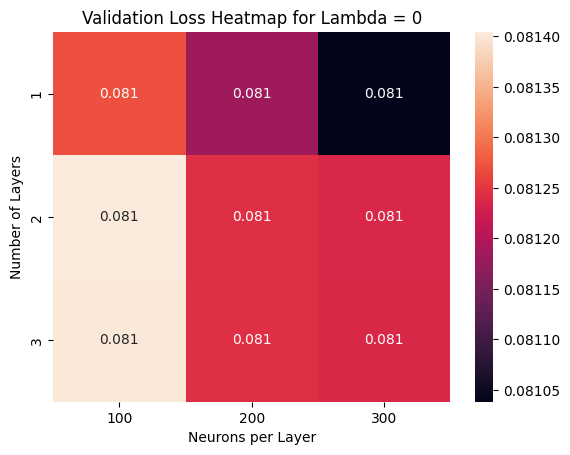

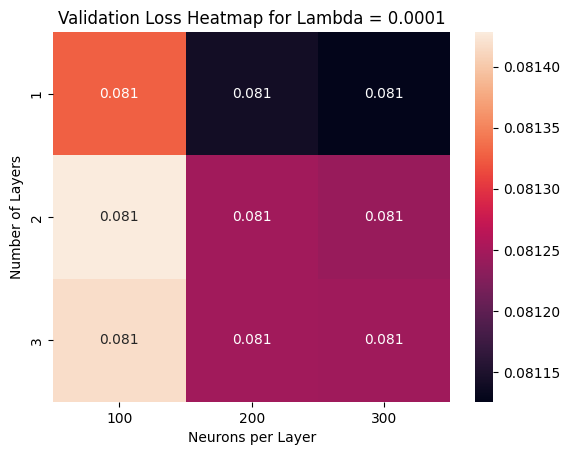

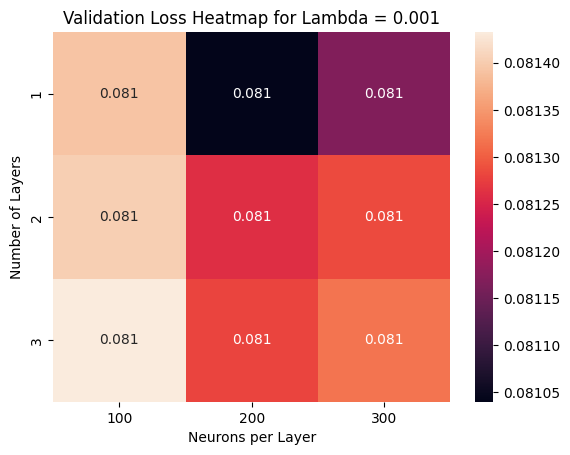

In [51]:
# Generate heatmaps for different lambda values
for lambd in lambdas:
    val_losses = np.zeros((len(layers_list), len(neurons_list)))
    for layers, neurons, lambd_, val_loss, _, _ in results:
        if lambd_ == lambd:
            val_losses[layers_list.index(layers), neurons_list.index(neurons)] = val_loss
    plt.figure()
    sns.heatmap(val_losses, annot=True, xticklabels=neurons_list, yticklabels=layers_list)
    plt.title(f'Validation Loss Heatmap for Lambda = {lambd}')
    plt.xlabel('Neurons per Layer')
    plt.ylabel('Number of Layers')
    plt.show()

In [52]:
# Train the final model using the best configuration
best_layers, best_neurons, best_lambd = best_config
nn = NeuralNetwork(input_dim, output_dim, best_layers, best_neurons, best_lambd)
nn.train(X_train, y_train, epochs=50, learning_rate=0.01, X_val=X_val, y_val=y_val)
y_pred = nn.forward(X_test)

# Evaluate performance using RMSE
rmse_heating = np.sqrt(mean_squared_error(y1_test, y_pred[:, 0]))
rmse_cooling = np.sqrt(mean_squared_error(y2_test, y_pred[:, 1]))
print(f'Final RMSE on test set - Heating Load: {rmse_heating}, Cooling Load: {rmse_cooling}')

Epoch 0: Train Loss = 0.07988274195201385, Validation Loss = 0.09241884183336393
Epoch 10: Train Loss = 0.06834368665060701, Validation Loss = 0.08171982485732428
Epoch 20: Train Loss = 0.06812405864430916, Validation Loss = 0.0811627290495447
Epoch 30: Train Loss = 0.06808809680940654, Validation Loss = 0.08107056339902438
Epoch 40: Train Loss = 0.06805546659063476, Validation Loss = 0.0810267400219386
Final RMSE on test set - Heating Load: 0.25738869765333955, Cooling Load: 0.25292052226420536


# Classification

**Download the data from ECLASS**
- drug_side_effects.csv
- drug_features.csv

**Dataset description:**

In this exercise, you will build and train a neural network to predict the occurrence of drug side effects. The dataset is derived from the SIDER dataset, containing relatively common side effects that can occur for at least 50 drugs. This produces a total of 740 drugs and 256 side effects. The features represent various molecular properties, including molecular weight, number of atoms, number of rings, number of hydrogen bond donors and acceptors, logP, topological polar surface area (TPSA), number of rotatable bonds, number of aromatic rings, number of aliphatic rings, number of saturated rings, and number of heteroatoms. 

**Remember that each drug can cause many side effects, not only one.** 

*Feel free to explore the dataset and check the potential side effects of popular medications!*

### To complete this exercise, follow these steps:

1. Load the dataset and split it into training, validation, and test sets, using an 80:10:10 ratio. 

2. Standardize the features by removing the mean and scaling to unit variance. To do this, perform the following for each feature (column) in the dataset:
    - Calculate the mean and standard deviation across the training set for that feature.
    - Subtract the mean from each value in that feature and divide by the standard deviation.
    - Apply the same transformation to the validation and test sets using the mean and standard deviation calculated from the training set.

**Observation:** you need to code this part, you’re not allowed to use scikit-learn.

*Normalization of features is important for neural networks because:*
- *It ensures that all features have the same scale, preventing certain features from dominating the learning process due to their larger magnitude.*
- *It improves the numerical stability of the training process, making the neural network less sensitive to the choice of learning rate and other hyperparameters.*

3. Build a neural network using NumPy that takes in the features as input and predicts the occurrence of side effects. You will choose the number of neurons per layer and the number of layers. You will provide this information as an input list where the length of the list determines the number of hidden layers, and each element is the number of neurons of that hidden layer. For example, an array `layers = [64,128,256]` should produce a network with 4 layers, with 3 hidden layers with 64, 128, and 256 neurons each. For the hidden layers use the sigmoid activation function. You will need to regularize your neural network using weight decay, that is, you will include a regularization term in your error function.

4. Code the forward pass and backpropagation algorithm to learn the weights of the neural network. Use the training set to train the neural network and update the weights using stochastic gradient descent. Don’t forget about the biases. 

5. Monitor the training by plotting the training and validation losses across the epochs.

	**Observation:** make sure the loss goes down during training, acceptable values are within 0.2 – 2.8 approximately. These values depend on the choice of the different hyperparameters. Test only sensible values taking into account the dataset, i.e., number of features, drugs, side effects. 

The performance of your neural network will be different depending on the number of layers, number of neurons per layer and the value of λ that controls the amount of weight decay. You will experiment with 3 values of λ: 0 (no weight decay), 1 and 0.01.
To choose the best network configuration and assess its performance you will:

1. For each value of λ, select 3 different layer configurations (note that in this exercise, the number of neurons per layer does not require to be the same for each layer).
2. Calculate the loss for each configuration on the validation set.
3. At the end of this process, you should be left with 9 loss values (one for each configuration). Train your final model selecting the best combination of hyper-parameters and evaluate the final performance of the neural network using the test set and the Area Under the ROC Curve (AUROC) with the function provided in the Jupyter notebook. 
	
	*Observation: don’t expect impressive AUROC values, as this is a highly complex problem that can’t be solved easily with a simple neural network with standard features. Expect values in the range (0.55-0.75).*

**Important:**
- Train for 50 epochs.
- Set the learning rate η to 0.01.



In [53]:
# Load the datasets
drug_features = pd.read_csv("drug_features.csv")
drug_side_effects = pd.read_csv("drug_side_effects.csv")

# Remove the first column (drug names) from both datasets
drug_features = drug_features.iloc[:, 1:].values
drug_side_effects = drug_side_effects.iloc[:, 1:].values

# Split the dataset into training, validation, and test sets
def train_val_test_split(X, y, train_ratio=0.8, val_ratio=0.1):
    n = len(X)
    train_size = int(train_ratio * n)
    val_size = int(val_ratio * n)
    indices = np.random.permutation(n)
    train_idx, val_idx, test_idx = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]
    return X[train_idx], X[val_idx], X[test_idx], y[train_idx], y[val_idx], y[test_idx]

X = drug_features
y = drug_side_effects

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

# Standardize the features
def standardize(train, val, test):
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    train_std = (train - mean) / std
    val_std = (val - mean) / std
    test_std = (test - mean) / std
    return train_std, val_std, test_std

X_train, X_val, X_test = standardize(X_train, X_val, X_test)

# Define the neural network class
class NeuralNetwork:
    def __init__(self, layers, input_dim, output_dim, lambd=0):
        self.layers = layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lambd = lambd
        self.weights = []
        self.biases = []
        self.init_weights()

    def init_weights(self):
        layer_dims = [self.input_dim] + self.layers + [self.output_dim]
        for i in range(len(layer_dims) - 1):
            self.weights.append(np.random.randn(layer_dims[i], layer_dims[i+1]) * 0.01)
            self.biases.append(np.zeros((1, layer_dims[i+1])))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        return z * (1 - z)

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for w, b in zip(self.weights, self.biases):
            z = np.dot(self.activations[-1], w) + b
            self.z_values.append(z)
            self.activations.append(self.sigmoid(z))
        return self.activations[-1]

    def backward(self, X, y, output):
        deltas = [output - y]
        for i in reversed(range(len(self.weights) - 1)):
            delta = np.dot(deltas[-1], self.weights[i + 1].T) * self.sigmoid_derivative(self.activations[i + 1])
            deltas.append(delta)
        deltas.reverse()

        dw = [np.dot(self.activations[i].T, deltas[i]) / X.shape[0] for i in range(len(self.weights))]
        db = [np.sum(deltas[i], axis=0, keepdims=True) / X.shape[0] for i in range(len(self.biases))]

        for i in range(len(self.weights)):
            dw[i] += self.lambd * self.weights[i] / X.shape[0]

        return dw, db

    def update_weights(self, dw, db, learning_rate):
        for i in range(len(self.weights)):
            self.weights[i] -= learning_rate * dw[i]
            self.biases[i] -= learning_rate * db[i]

    def compute_loss(self, y, output):
        m = y.shape[0]
        logprobs = - np.multiply(y, np.log(output)) - np.multiply(1 - y, np.log(1 - output))
        data_loss = np.sum(logprobs) / m
        reg_loss = (self.lambd / (2 * m)) * sum([np.sum(np.square(w)) for w in self.weights])
        return data_loss + reg_loss

    def train(self, X, y, epochs, learning_rate, X_val, y_val):
        train_losses = []
        val_losses = []
        for epoch in range(epochs):
            output = self.forward(X)
            dw, db = self.backward(X, y, output)
            self.update_weights(dw, db, learning_rate)
            train_loss = self.compute_loss(y, output)
            val_output = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_output)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            if epoch % 10 == 0:
                print(f'Epoch {epoch}: Train Loss = {train_loss}, Validation Loss = {val_loss}')
        return train_losses, val_losses

# Train the neural network with different configurations
def experiment(layers_list, lambdas, input_dim, output_dim, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, learning_rate=0.01):
    best_config = None
    best_val_loss = float('inf')
    results = []

    for lambd in lambdas:
        for layers in layers_list:
            print(f'Training with layers {layers} and lambda {lambd}')
            nn = NeuralNetwork(layers, input_dim, output_dim, lambd)
            train_losses, val_losses = nn.train(X_train, y_train, epochs, learning_rate, X_val, y_val)
            val_loss = val_losses[-1]
            results.append((layers, lambd, val_loss, train_losses, val_losses))
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = (layers, lambd)

    best_layers, best_lambd = best_config
    print(f'Best configuration: Layers = {best_layers}, Lambda = {best_lambd}')
    nn = NeuralNetwork(best_layers, input_dim, output_dim, best_lambd)
    nn.train(X_train, y_train, epochs, learning_rate, X_val, y_val)
    y_pred = nn.forward(X_test)
    auroc = roc_auc_score(y_test, y_pred)
    print(f'Final AUROC on test set: {auroc}')
    return results

layers_list = [[64, 128, 256], [128, 256, 512], [256, 128, 64]]
lambdas = [0, 0.01, 1]
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]

results = experiment(layers_list, lambdas, input_dim, output_dim, X_train, y_train, X_val, y_val, X_test, y_test)

Training with layers [64, 128, 256] and lambda 0
Epoch 0: Train Loss = 177.547434570353, Validation Loss = 160.1284146465933
Epoch 10: Train Loss = 109.37227840076443, Validation Loss = 118.55691985985622
Epoch 20: Train Loss = 105.00663759230852, Validation Loss = 117.45278819998401
Epoch 30: Train Loss = 104.53163344454441, Validation Loss = 117.75395572838511
Epoch 40: Train Loss = 104.45627898648874, Validation Loss = 117.92276958324186
Training with layers [128, 256, 512] and lambda 0
Epoch 0: Train Loss = 176.93297870857114, Validation Loss = 145.8350321691913
Epoch 10: Train Loss = 105.14507181852602, Validation Loss = 117.4382244181296
Epoch 20: Train Loss = 104.47196823801703, Validation Loss = 117.87565283635278
Epoch 30: Train Loss = 104.43930493247804, Validation Loss = 118.010382732736
Epoch 40: Train Loss = 104.43667597750826, Validation Loss = 118.04527778049032
Training with layers [256, 128, 64] and lambda 0
Epoch 0: Train Loss = 177.30489004481123, Validation Loss = 1

Final AUROC on test set: 0.5750182948882538

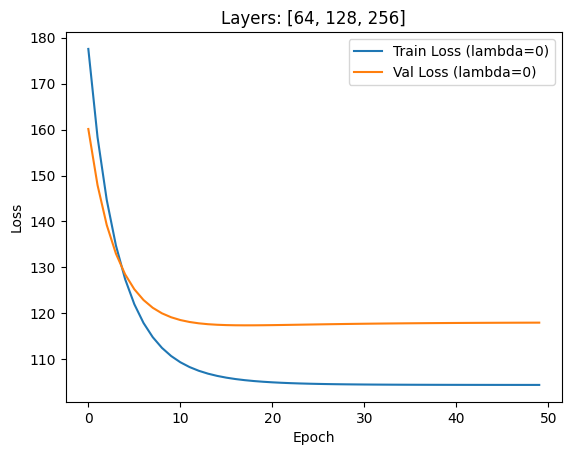

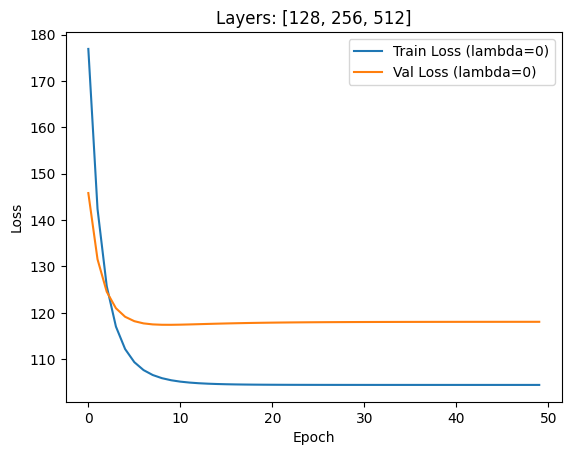

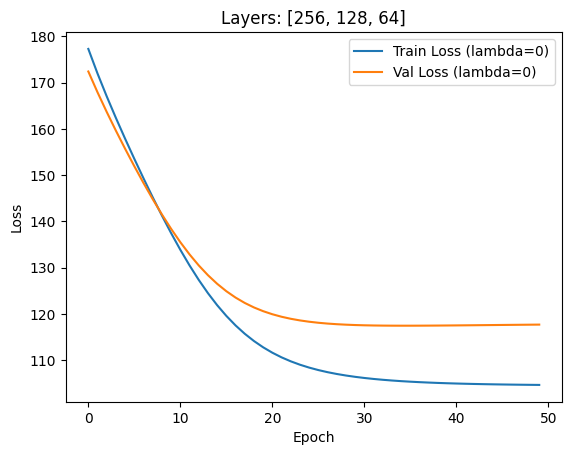

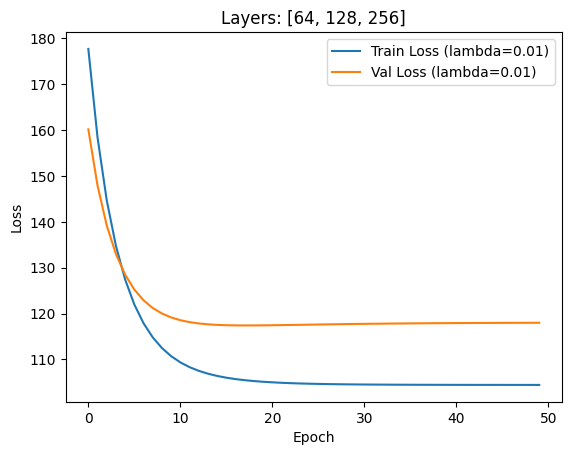

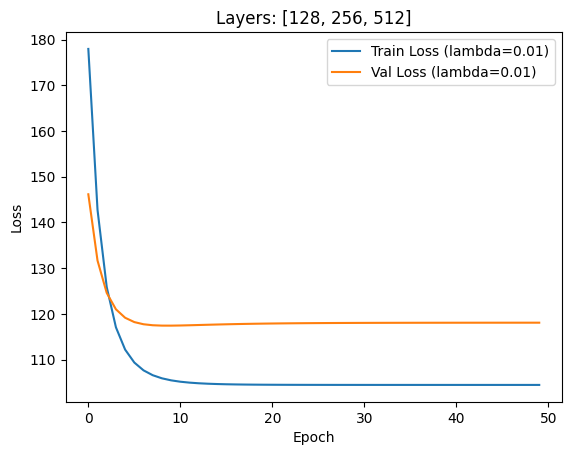

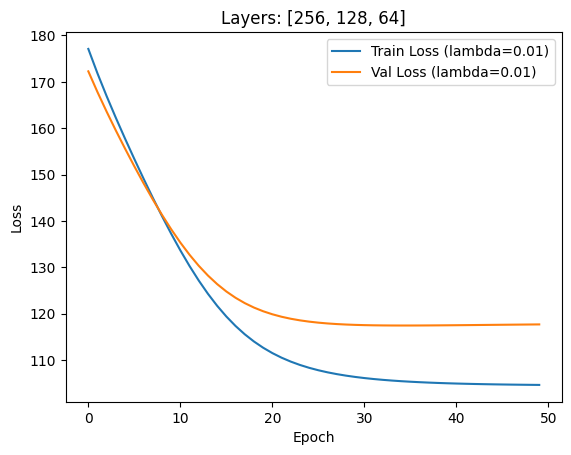

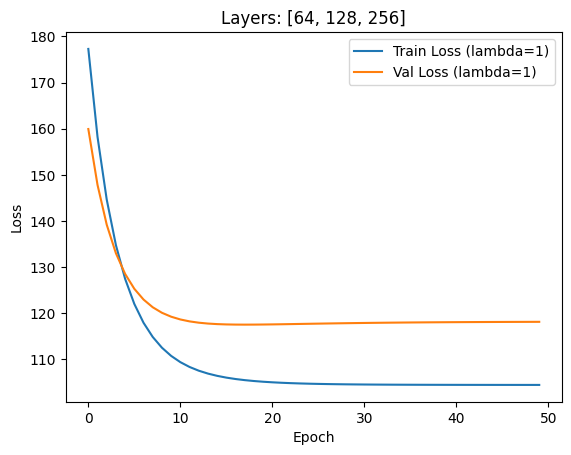

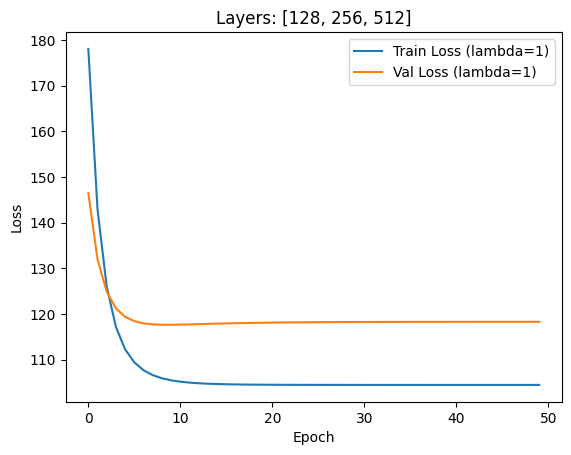

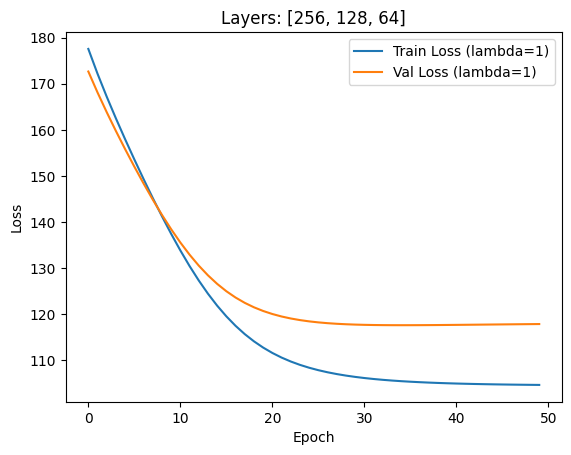

In [54]:
# Plot training and validation losses for each layer configuration separately
for layers, lambd, val_loss, train_losses, val_losses in results:
    plt.figure()
    plt.plot(train_losses, label=f'Train Loss (lambda={lambd})')
    plt.plot(val_losses, label=f'Val Loss (lambda={lambd})')
    plt.title(f'Layers: {layers}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()